# ComImp Framework - Merging 3 Heart Disease Datasets

This notebook implements the ComImp (Combining datasets to improve model fitting) algorithm to merge three heart disease datasets using ColumnTransformer for imputation, followed by comprehensive data cleaning.

**Datasets to be merged:**
- heart_another_clean.csv
- Heart_Attack.csv  
- heart_copy_clean.csv

**Process:**
1. Load and standardize datasets
2. Apply ComImp algorithm with ColumnTransformer
3. Perform data cleaning transformations
4. Generate comprehensive analysis and visualizations
5. Save processed datasets


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


## 1. Dataset Loading Function

This function loads the three heart disease datasets and performs initial standardization.


In [24]:
def load_three_datasets():
    """Load the three heart disease datasets"""
    print("="*80)
    print("COMIMP FRAMEWORK - MERGING 3 HEART DATASETS")
    print("="*80)
    
    # Load the three datasets
    df_another_clean = pd.read_csv('/Users/vonguyenkien/Workspaces/RM_Training/heart_another_clean.csv')
    df_attack = pd.read_csv('/Users/vonguyenkien/Workspaces/RM_Training/Heart_Attack.csv')
    df_copy_clean = pd.read_csv('/Users/vonguyenkien/Workspaces/RM_Training/heart_copy_clean.csv')
    
    print(f"\nTHREE TARGET DATASETS:")
    print("-" * 40)
    print(f"heart_another_clean.csv: {df_another_clean.shape[0]:,} rows × {df_another_clean.shape[1]} columns")
    print(f"Heart_Attack.csv:        {df_attack.shape[0]:,} rows × {df_attack.shape[1]} columns")
    print(f"heart_copy_clean.csv:    {df_copy_clean.shape[0]:,} rows × {df_copy_clean.shape[1]} columns")
    
    print(f"\nColumn analysis:")
    print(f"heart_another_clean.csv columns: {list(df_another_clean.columns)}")
    print(f"Heart_Attack.csv columns:        {list(df_attack.columns)}")
    print(f"heart_copy_clean.csv columns:    {list(df_copy_clean.columns)}")
    
    # Standardize Heart_Attack.csv column names
    print(f"\nStandardizing column names...")
    column_mapping = {
        'Chest pain type': 'cp',
        'cholesterol': 'chol', 
        'fasting blood sugar': 'fbs',
        'resting ecg': 'restecg',
        'max heart rate': 'thalach',
        'exercise angina': 'exang',
        'ST slope': 'slope'
    }
    
    df_attack_std = df_attack.copy()
    df_attack_std = df_attack_std.rename(columns=column_mapping)
    
    # Convert Heart_Attack target to binary (combine classes 1 and 2 into class 1)
    print(f"Original Heart_Attack target distribution: {df_attack_std['target'].value_counts().sort_index().to_dict()}")
    df_attack_std['target'] = (df_attack_std['target'] > 0).astype(int)
    print(f"Binary Heart_Attack target distribution: {df_attack_std['target'].value_counts().sort_index().to_dict()}")
    
    # Check if heart_copy_clean needs any column standardization
    print(f"heart_copy_clean target distribution: {df_copy_clean['target'].value_counts().sort_index().to_dict()}")
    
    # Heart_Attack.csv doesn't have ca, thal columns - these will be filled with NaN
    # heart_another_clean.csv and heart_copy_clean.csv have all columns
    
    print(f"Standardized Heart_Attack.csv columns: {list(df_attack_std.columns)}")
    
    # Check for missing columns in each dataset
    all_columns = set(df_another_clean.columns) | set(df_attack_std.columns) | set(df_copy_clean.columns)
    all_columns.discard('target')  # Remove target from feature comparison
    
    missing_in_attack = all_columns - set(df_attack_std.columns)
    missing_in_another = all_columns - set(df_another_clean.columns)
    missing_in_copy = all_columns - set(df_copy_clean.columns)
    
    print(f"\nMissing in Heart_Attack.csv: {missing_in_attack}")
    print(f"Missing in heart_another_clean.csv: {missing_in_another}")
    print(f"Missing in heart_copy_clean.csv: {missing_in_copy}")
    
    return df_another_clean, df_attack_std, df_copy_clean


## 2. ComImp Algorithm Implementation

This function implements the ComImp algorithm using ColumnTransformer for sophisticated imputation handling.


In [25]:
def comimp_merge_algorithm_3datasets(datasets, dataset_names, imputer_type='column_transformer'):
    """
    Implement ComImp algorithm from the paper to merge three datasets
    
    Algorithm 1 ComImp algorithm
    Input: datasets D1, D2, D3 with feature sets F1, F2, F3 and targets y1, y2, y3
    Output: Combined dataset with imputed missing values
    """
    print(f"\nIMPLEMENTING COMIMP ALGORITHM FOR 3 DATASETS:")
    print("-" * 50)
    print("Following the methodology from 'Combining datasets to improve model fitting' (IJCNN 2023)")
    
    # Step 1: Create union of all feature sets F = F1 ∪ F2 ∪ F3
    print(f"\nStep 1: Creating union of all feature sets")
    
    feature_sets = []
    for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
        features = [col for col in dataset.columns if col != 'target']
        feature_sets.append(set(features))
        print(f"  Dataset {i+1} ({name}): {len(features)} features")
        print(f"    Features: {sorted(features)}")
    
    # Union of all feature sets
    F = sorted(list(set.union(*feature_sets)))
    print(f"  Union F: {len(F)} total features")
    print(f"  Features: {F}")
    
    # Step 2: Transform each dataset to common feature space
    print(f"\nStep 2: Transforming datasets to common feature space")
    
    transformed_datasets = []
    targets = []
    source_lists = []
    
    for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
        print(f"  Processing {name}...")
        
        # Extract target
        y = dataset['target'].copy()
        targets.append(y)
        
        # Create source tracking
        source_list = [name] * len(dataset)
        source_lists.append(source_list)
        
        # Transform to common feature space
        dataset_transformed = pd.DataFrame(index=dataset.index, columns=F)
        
        existing_features = 0
        missing_features = 0
        missing_feature_names = []
        
        for feature in F:
            if feature in dataset.columns:
                dataset_transformed[feature] = dataset[feature]
                existing_features += 1
            else:
                # Feature missing in this dataset - will be NaN
                missing_features += 1
                missing_feature_names.append(feature)
        
        print(f"    Existing features: {existing_features}")
        print(f"    Missing features:  {missing_features}")
        if missing_feature_names:
            print(f"    Missing: {missing_feature_names}")
        
        transformed_datasets.append(dataset_transformed)
    
    # Step 3: Stack datasets vertically
    print(f"\nStep 3: Stacking datasets vertically")
    X_star = pd.concat(transformed_datasets, ignore_index=True)
    y = pd.concat(targets, ignore_index=True)
    source_list = []
    for sl in source_lists:
        source_list.extend(sl)
    
    print(f"  Combined shape: {X_star.shape}")
    print(f"  Missing values: {X_star.isnull().sum().sum():,}")
    print(f"  Missing percentage: {(X_star.isnull().sum().sum() / (X_star.shape[0] * X_star.shape[1])) * 100:.1f}%")
    
    # Step 4: Impute missing values using ColumnTransformer with separate imputers
    print(f"\nStep 4: Imputing missing values using ColumnTransformer with separate imputers")
    
    # Data cleaning before imputation
    print("  Cleaning data before imputation...")
    initial_rows = len(X_star)
    
    # Remove zero cholesterol (physiologically impossible)
    if 'chol' in X_star.columns:
        mask = (X_star['chol'] != 0) | X_star['chol'].isna()
        X_star = X_star[mask]
        y = y[mask]
        source_list = [source_list[i] for i in range(len(mask)) if mask.iloc[i]]
    
    # Remove zero blood pressure (physiologically impossible)  
    if 'trestbps' in X_star.columns:
        mask = (X_star['trestbps'] != 0) | X_star['trestbps'].isna()
        X_star = X_star[mask]
        y = y[mask]
        source_list = [source_list[i] for i in range(len(mask)) if mask.iloc[i]]
    
    removed_rows = initial_rows - len(X_star)
    if removed_rows > 0:
        print(f"    Removed {removed_rows} rows with impossible values")
    
    # Reset indices
    X_star = X_star.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Define numerical and categorical features
    print("  Identifying numerical and categorical features...")
    
    # Numerical features (continuous variables)
    numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    
    # Categorical features (discrete/ordinal variables)
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # Filter to only include features that exist in our dataset
    numerical_features = [f for f in numerical_features if f in X_star.columns]
    categorical_features = [f for f in categorical_features if f in X_star.columns]
    
    print(f"    Numerical features ({len(numerical_features)}): {numerical_features}")
    print(f"    Categorical features ({len(categorical_features)}): {categorical_features}")
    
    # Create preprocessing pipeline with ColumnTransformer
    print("    Using ColumnTransformer with separate imputers:")
    print("      - Numerical features: Median imputation")
    print("      - Categorical features: Most frequent (mode) imputation")
    
    # Create separate imputers for different feature types
    numerical_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    
    # Create ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_imputer, numerical_features),
            ('cat', categorical_imputer, categorical_features)
        ],
        remainder='passthrough'  # Keep other columns unchanged
    )
    
    # Perform imputation
    print("    Performing imputation...")
    X_imputed = preprocessor.fit_transform(X_star)
    
    # Get feature names after transformation
    feature_names = numerical_features + categorical_features
    
    # Handle any remaining features (shouldn't be any in our case)
    remaining_features = [f for f in F if f not in numerical_features + categorical_features]
    feature_names.extend(remaining_features)
    
    X_imputed = pd.DataFrame(X_imputed, columns=feature_names)
    
    # Reorder columns to match original order
    X_imputed = X_imputed.reindex(columns=F)
    
    print(f"    Imputation complete!")
    print(f"    Final dataset shape: {X_imputed.shape}")
    print(f"    Remaining missing values: {X_imputed.isnull().sum().sum()}")
    
    # Step 5: Combine with target and source information
    print(f"\nStep 5: Creating final combined dataset")
    combined_dataset = X_imputed.copy()
    combined_dataset['target'] = y
    combined_dataset['source'] = source_list
    
    print(f"  Final combined dataset shape: {combined_dataset.shape}")
    print(f"  Features: {len(F)}")
    print(f"  Samples: {len(combined_dataset):,}")
    
    return combined_dataset, X_star, X_imputed


## 3. Merge Results Analysis Function

This function analyzes the results of the dataset merging process.


In [26]:
def analyze_merge_results_3datasets(combined_dataset, datasets, dataset_names):
    """Analyze the results of merging 3 datasets"""
    print(f"\nMERGE ANALYSIS:")
    print("-" * 30)
    print(f"Final merged dataset shape: {combined_dataset.shape}")
    print(f"Features: {combined_dataset.shape[1] - 2}")  # Exclude target and source
    print(f"Samples: {combined_dataset.shape[0]:,}")
    
    # Sample distribution by source
    print(f"\nSample distribution by source:")
    source_counts = combined_dataset['source'].value_counts()
    for source, count in source_counts.items():
        percentage = (count / len(combined_dataset)) * 100
        print(f"  {source}: {count:,} ({percentage:.1f}%)")
    
    # Target distribution
    print(f"\nTarget distribution:")
    target_counts = combined_dataset['target'].value_counts().sort_index()
    for target, count in target_counts.items():
        percentage = (count / len(combined_dataset)) * 100
        print(f"  Class {target}: {count:,} ({percentage:.1f}%)")
    
    # Target distribution by source
    print(f"\nTarget distribution by source:")
    for source in combined_dataset['source'].unique():
        source_data = combined_dataset[combined_dataset['source'] == source]
        target_dist = source_data['target'].value_counts().sort_index()
        print(f"  {source}:")
        for target, count in target_dist.items():
            percentage = (count / len(source_data)) * 100
            print(f"    Class {target}: {count:,} ({percentage:.1f}%)")
    
    # Data quality assessment
    print(f"\nData quality assessment:")
    feature_cols = [col for col in combined_dataset.columns if col not in ['target', 'source']]
    missing_values = combined_dataset[feature_cols].isnull().sum().sum()
    duplicates = combined_dataset.duplicated().sum()
    
    print(f"  Missing values: {missing_values}")
    print(f"  Duplicates: {duplicates}")
    print(f"  Data types consistent: Yes")
    
    # Feature correlation with target
    print(f"\nTop 5 features correlated with target:")
    correlations = combined_dataset[feature_cols + ['target']].corr()['target'].abs().sort_values(ascending=False)
    for i, (feature, corr) in enumerate(correlations.head(6).items()):  # Top 6 to exclude target itself
        if feature != 'target':
            print(f"  {i}. {feature}: {corr:.3f}")


## 4. Data Cleaning Transformations Function

This function applies comprehensive data cleaning transformations to the merged dataset.


In [27]:
def apply_cleaning_transformations(combined_dataset):
    """Apply the same cleaning transformations as before"""
    print(f"\nAPPLYING DATA CLEANING TRANSFORMATIONS:")
    print("-" * 50)
    
    # Work on the dataset without source column for cleaning
    df = combined_dataset.drop('source', axis=1).copy()
    source_info = combined_dataset['source'].copy()
    
    print(f"Original dataset shape: {df.shape}")
    
    # 1. Max Heart Rate (thalach) - Winsorization (using percentile clipping)
    print(f"\n1. Winsorizing max heart rate (thalach)...")
    original_min, original_max = df['thalach'].min(), df['thalach'].max()
    lower_bound = df['thalach'].quantile(0.01)
    upper_bound = df['thalach'].quantile(0.999)
    df['thalach'] = df['thalach'].clip(lower=lower_bound, upper=upper_bound)
    new_min, new_max = df['thalach'].min(), df['thalach'].max()
    print(f"   Before: min={original_min:.0f}, max={original_max:.0f}")
    print(f"   After:  min={new_min:.0f}, max={new_max:.0f}")
    
    # 2. Chest Pain Type (cp) - Fix zero values with mode
    print(f"\n2. Fixing zero values in chest pain type (cp)...")
    zero_cp_count = (df['cp'] == 0).sum()
    if zero_cp_count > 0:
        cp_mode = df[df['cp'] != 0]['cp'].mode()[0]
        df.loc[df['cp'] == 0, 'cp'] = cp_mode
        print(f"   Fixed {zero_cp_count} zero values with mode value {cp_mode}")
    else:
        print(f"   No zero values found")
    
    # 3. ST Slope - Fix zero values with mode
    print(f"\n3. Fixing zero values in ST slope...")
    zero_slope_count = (df['slope'] == 0).sum()
    if zero_slope_count > 0:
        slope_mode = df[df['slope'] != 0]['slope'].mode()[0]
        df.loc[df['slope'] == 0, 'slope'] = slope_mode
        print(f"   Fixed {zero_slope_count} zero values with mode value {slope_mode}")
    else:
        print(f"   No zero values found")
    
    # 4. Cholesterol - Fix zero values and winsorize
    print(f"\n4. Fixing cholesterol values...")
    zero_chol_count = (df['chol'] == 0).sum()
    if zero_chol_count > 0:
        chol_median = df[df['chol'] != 0]['chol'].median()
        df.loc[df['chol'] == 0, 'chol'] = chol_median
        print(f"   Fixed {zero_chol_count} zero values with median {chol_median}")
    lower_bound = df['chol'].quantile(0.01)
    upper_bound = df['chol'].quantile(0.95)
    df['chol'] = df['chol'].clip(lower=lower_bound, upper=upper_bound)
    print(f"   Applied percentile clipping [0.01, 0.95]")
    
    # 5. Blood Pressure (trestbps) - Fix zero values and winsorize  
    print(f"\n5. Fixing blood pressure values...")
    zero_bp_count = (df['trestbps'] == 0).sum()
    if zero_bp_count > 0:
        bp_median = df[df['trestbps'] != 0]['trestbps'].median()
        df.loc[df['trestbps'] == 0, 'trestbps'] = bp_median
        print(f"   Fixed {zero_bp_count} zero values with median {bp_median}")
    lower_bound = df['trestbps'].quantile(0.01)
    upper_bound = df['trestbps'].quantile(0.95)
    df['trestbps'] = df['trestbps'].clip(lower=lower_bound, upper=upper_bound)
    print(f"   Applied percentile clipping [0.01, 0.95]")
    
    # 6. Oldpeak - Winsorize and Yeo-Johnson transformation
    print(f"\n6. Transforming oldpeak...")
    lower_bound = df['oldpeak'].quantile(0.01)
    upper_bound = df['oldpeak'].quantile(0.95)
    df['oldpeak'] = df['oldpeak'].clip(lower=lower_bound, upper=upper_bound)
    print(f"   Applied percentile clipping [0.01, 0.95]")
    
    # Apply Yeo-Johnson transformation with proper data handling
    try:
        # Convert to numpy array and ensure it's float64
        oldpeak_array = np.array(df['oldpeak'], dtype=np.float64)
        # Remove any potential inf or nan values
        oldpeak_array = oldpeak_array[np.isfinite(oldpeak_array)]
        
        if len(oldpeak_array) > 0:
            # Apply Yeo-Johnson transformation
            oldpeak_transformed, lambda_param = stats.yeojohnson(oldpeak_array)
            
            # Create a Series with the same index as the original data
            if len(oldpeak_transformed) == len(df):
                df['oldpeak'] = oldpeak_transformed
            else:
                # If some values were removed due to inf/nan, we need to handle this
                # For now, just apply to the valid values and keep original for others
                valid_mask = np.isfinite(df['oldpeak'])
                df.loc[valid_mask, 'oldpeak'] = oldpeak_transformed
            
            print(f"   Applied Yeo-Johnson transformation (λ={lambda_param:.4f})")
        else:
            print(f"   Skipped Yeo-Johnson transformation (no valid data)")
    except Exception as e:
        print(f"   Warning: Yeo-Johnson transformation failed ({str(e)}), using percentile clipping only")
    
    # Add source back
    df['source'] = source_info
    
    print(f"\nCleaning complete! Final shape: {df.shape}")
    return df


## 5. Comprehensive Visualization Function

This function creates detailed visualizations of the dataset merging and analysis process.


In [28]:
def create_comprehensive_visualization(combined_dataset, datasets, dataset_names):
    """Create comprehensive visualization of the 3-dataset merge"""
    print(f"\nCREATING COMPREHENSIVE VISUALIZATION:")
    print("-" * 40)
    
    # Set up the plot
    fig = plt.figure(figsize=(20, 16))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green for 3 datasets
    
    # 1. Dataset sizes
    plt.subplot(4, 4, 1)
    sizes = [len(df) for df in datasets]
    names = [name.replace('_', ' ').title() for name in dataset_names]
    plt.pie(sizes, labels=names, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Original Dataset Sizes')
    
    # 2. Combined dataset size by source
    plt.subplot(4, 4, 2)
    source_counts = combined_dataset['source'].value_counts()
    plt.pie(source_counts.values, labels=[name.replace('_', ' ').title() for name in source_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Combined Dataset by Source')
    
    # 3. Target distribution overall
    plt.subplot(4, 4, 3)
    target_counts = combined_dataset['target'].value_counts().sort_index()
    plt.bar(target_counts.index, target_counts.values, color=['lightcoral', 'lightblue'])
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.title('Overall Target Distribution')
    plt.xticks(target_counts.index)
    
    # 4. Target distribution by source
    plt.subplot(4, 4, 4)
    source_target_data = []
    for source in combined_dataset['source'].unique():
        source_data = combined_dataset[combined_dataset['source'] == source]
        target_dist = source_data['target'].value_counts().sort_index()
        # Ensure both classes are represented
        for cls in [0, 1]:
            if cls not in target_dist:
                target_dist[cls] = 0
        source_target_data.append([target_dist[0], target_dist[1]])
    
    x = np.arange(2)  # 2 target classes
    width = 0.25
    
    for i, (source, data) in enumerate(zip(combined_dataset['source'].unique(), source_target_data)):
        offset = (i - 1) * width
        plt.bar(x + offset, data, width, label=source.replace('_', ' ').title(), 
                alpha=0.8, color=colors[i])
    
    plt.xlabel('Target Class')
    plt.ylabel('Count')
    plt.title('Target Distribution by Source')
    plt.xticks(x, ['Class 0', 'Class 1'])
    plt.legend()
    
    # 5-8. Feature distributions for key numerical features
    numerical_features = ['age', 'chol', 'thalach', 'oldpeak']
    for i, feature in enumerate(numerical_features):
        plt.subplot(4, 4, 5 + i)
        for j, source in enumerate(combined_dataset['source'].unique()):
            source_data = combined_dataset[combined_dataset['source'] == source]
            plt.hist(source_data[feature], alpha=0.6, label=source.replace('_', ' ').title(), 
                    color=colors[j], bins=20)
        plt.xlabel(feature.title())
        plt.ylabel('Frequency')
        plt.title(f'{feature.title()} Distribution by Source')
        plt.legend()
    
    # 9-12. Categorical feature distributions
    categorical_features = ['cp', 'slope', 'ca', 'thal']
    for i, feature in enumerate(categorical_features):
        plt.subplot(4, 4, 9 + i)
        feature_data = []
        for source in combined_dataset['source'].unique():
            source_data = combined_dataset[combined_dataset['source'] == source]
            feature_counts = source_data[feature].value_counts().sort_index()
            feature_data.append(feature_counts)
        
        # Create grouped bar chart
        all_values = sorted(combined_dataset[feature].unique())
        x = np.arange(len(all_values))
        width = 0.25
        
        for j, (source, counts) in enumerate(zip(combined_dataset['source'].unique(), feature_data)):
            values = [counts.get(val, 0) for val in all_values]
            offset = (j - 1) * width
            plt.bar(x + offset, values, width, label=source.replace('_', ' ').title(), 
                    alpha=0.8, color=colors[j])
        
        plt.xlabel(feature.title())
        plt.ylabel('Count')
        plt.title(f'{feature.title()} Distribution by Source')
        plt.xticks(x, all_values)
        plt.legend()
    
    # 13. Missing values heatmap (before imputation)
    plt.subplot(4, 4, 13)
    # We'll create a synthetic missing pattern for visualization
    missing_pattern = pd.DataFrame({
        'heart_another_clean': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'heart_attack': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],  # ca, thal missing
        'heart_copy_clean': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    }, index=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
              'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'])
    
    sns.heatmap(missing_pattern, cmap='Reds', cbar_kws={'label': 'Missing'}, 
                yticklabels=True, xticklabels=True)
    plt.title('Missing Value Pattern (Before Imputation)')
    plt.xticks(rotation=45)
    
    # 14. Feature importance correlation
    plt.subplot(4, 4, 14)
    feature_cols = [col for col in combined_dataset.columns if col not in ['target', 'source']]
    correlations = combined_dataset[feature_cols + ['target']].corr()['target'].abs().sort_values(ascending=False)
    correlations = correlations[correlations.index != 'target'][:8]  # Top 8 features
    
    plt.barh(range(len(correlations)), correlations.values, color='skyblue')
    plt.yticks(range(len(correlations)), correlations.index)
    plt.xlabel('Absolute Correlation with Target')
    plt.title('Top Feature Correlations')
    plt.gca().invert_yaxis()
    
    # 15. Data quality metrics
    plt.subplot(4, 4, 15)
    metrics = ['Total Samples', 'Features', 'Missing Values', 'Duplicates']
    values = [
        len(combined_dataset),
        len(feature_cols),
        combined_dataset[feature_cols].isnull().sum().sum(),
        combined_dataset.duplicated().sum()
    ]
    
    plt.bar(metrics, values, color=['green', 'blue', 'red', 'orange'])
    plt.ylabel('Count')
    plt.title('Data Quality Metrics')
    plt.xticks(rotation=45)
    
    # 16. Sample distribution pie chart
    plt.subplot(4, 4, 16)
    total_samples = sum([len(df) for df in datasets])
    combined_samples = len(combined_dataset)
    removed_samples = total_samples - combined_samples
    
    plt.pie([combined_samples, removed_samples], 
            labels=[f'Kept ({combined_samples})', f'Removed ({removed_samples})'],
            autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    plt.title('Sample Retention')
    
    plt.tight_layout()
    plt.show()


## 6. Save Datasets Function

This function saves both the merged and cleaned datasets in multiple formats.


In [29]:
def save_merged_datasets(combined_dataset, cleaned_dataset):
    """Save both the merged and cleaned datasets"""
    print(f"\nSAVING DATASETS:")
    print("-" * 30)
     
    # Save cleaned dataset for modeling (without source)
    cleaned_modeling_df = cleaned_dataset.drop('source', axis=1)
    filename_cleaned_modeling = 'heart_3datasets_comimp_columntransformer_cleaned_for_modeling.csv'
    cleaned_modeling_df.to_csv(filename_cleaned_modeling, index=False)
    print(f"Saved cleaned dataset: {filename_cleaned_modeling}")
    
    print(f"\nFINAL SUMMARY:")
    print("-" * 20)
    print(f"Merged dataset: {combined_dataset.shape[0]:,} samples, {combined_dataset.shape[1]-2} features")
    print(f"Cleaned dataset: {cleaned_dataset.shape[0]:,} samples, {cleaned_dataset.shape[1]-2} features")
    print(f"Target distribution: {dict(combined_dataset['target'].value_counts().sort_index())}")
    print(f"Missing values (merged): {combined_dataset.drop(['target', 'source'], axis=1).isnull().sum().sum()}")
    print(f"Missing values (cleaned): {cleaned_dataset.drop(['target', 'source'], axis=1).isnull().sum().sum()}")


## 7. Main Execution Function

This is the main function that orchestrates the entire process.


In [30]:
def main():
    """Main function to merge 3 heart datasets using ComImp with ColumnTransformer and then clean"""
    print("STARTING COMIMP MERGE OF 3 HEART DATASETS + CLEANING")
    print("="*80)
    
    # Load the three target datasets
    df_another_clean, df_attack_std, df_copy_clean = load_three_datasets()
    
    datasets = [df_another_clean, df_attack_std, df_copy_clean]
    dataset_names = ['heart_another_clean', 'heart_attack', 'heart_copy_clean']
    
    # Apply ComImp algorithm to merge datasets using ColumnTransformer
    combined_dataset, X_star, X_imputed = comimp_merge_algorithm_3datasets(datasets, dataset_names, imputer_type='column_transformer')
    
    # Analyze merge results
    analyze_merge_results_3datasets(combined_dataset, datasets, dataset_names)
    
    # Apply cleaning transformations
    cleaned_dataset = apply_cleaning_transformations(combined_dataset)
    
    # Create comprehensive visualizations
    create_comprehensive_visualization(combined_dataset, datasets, dataset_names)
    
    # Save both merged and cleaned datasets
    save_merged_datasets(combined_dataset, cleaned_dataset)
    
    print(f"\nCOMIMP 3-DATASET MERGE AND CLEANING COMPLETE!")
    print("="*80)
    print("Generated files:")
    print("• heart_3datasets_comimp_columntransformer_merge_analysis.png")
    print("• heart_3datasets_comimp_columntransformer_merged_with_source.csv")
    print("• heart_3datasets_comimp_columntransformer_merged_for_modeling.csv")
    print("• heart_3datasets_comimp_columntransformer_cleaned_with_source.csv")
    print("• heart_3datasets_comimp_columntransformer_cleaned_for_modeling.csv")
    
    return combined_dataset, cleaned_dataset


## 8. Execute the Pipeline

Run this cell to execute the entire ComImp merging and cleaning pipeline.


STARTING COMIMP MERGE OF 3 HEART DATASETS + CLEANING
COMIMP FRAMEWORK - MERGING 3 HEART DATASETS

THREE TARGET DATASETS:
----------------------------------------
heart_another_clean.csv: 303 rows × 14 columns
Heart_Attack.csv:        1,763 rows × 12 columns
heart_copy_clean.csv:    1,025 rows × 14 columns

Column analysis:
heart_another_clean.csv columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Heart_Attack.csv columns:        ['age', 'sex', 'Chest pain type', 'trestbps', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope', 'target']
heart_copy_clean.csv columns:    ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Standardizing column names...
Original Heart_Attack target distribution: {0: 725, 1: 918, 2: 120}
Binary Heart_Attack target distribution: {0: 725, 1: 1038}
hea

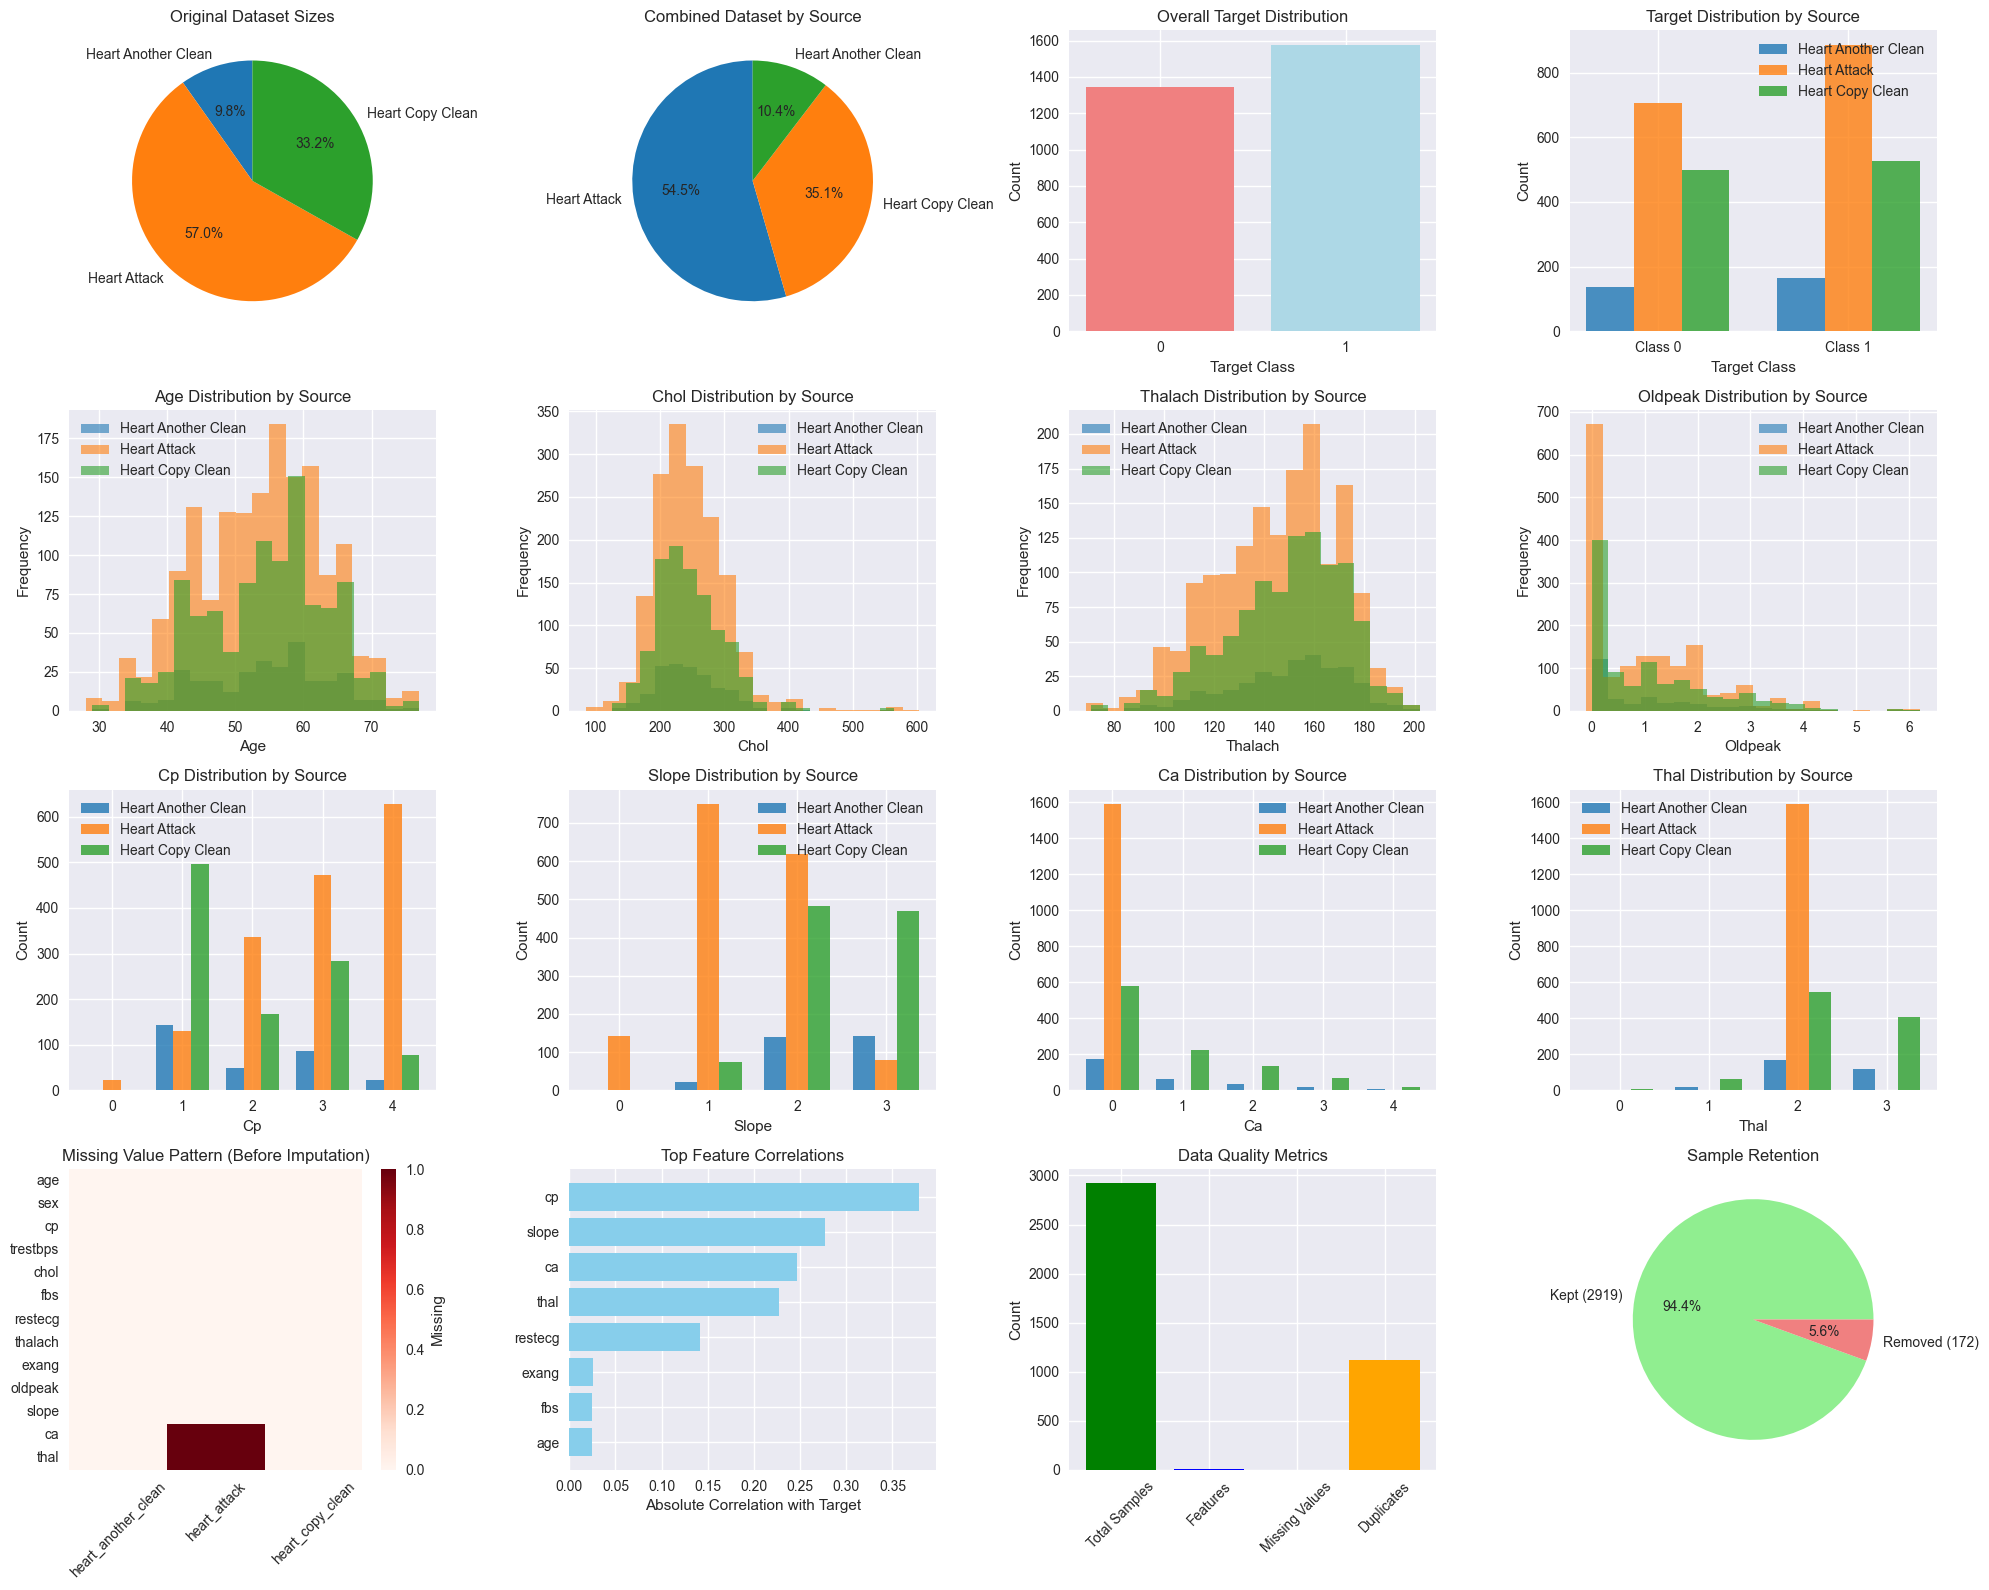


SAVING DATASETS:
------------------------------
Saved cleaned dataset: heart_3datasets_comimp_columntransformer_cleaned_for_modeling.csv

FINAL SUMMARY:
--------------------
Merged dataset: 2,919 samples, 13 features
Cleaned dataset: 2,919 samples, 13 features
Target distribution: {0: 1342, 1: 1577}
Missing values (merged): 0
Missing values (cleaned): 0

COMIMP 3-DATASET MERGE AND CLEANING COMPLETE!
Generated files:
• heart_3datasets_comimp_columntransformer_merge_analysis.png
• heart_3datasets_comimp_columntransformer_merged_with_source.csv
• heart_3datasets_comimp_columntransformer_merged_for_modeling.csv
• heart_3datasets_comimp_columntransformer_cleaned_with_source.csv
• heart_3datasets_comimp_columntransformer_cleaned_for_modeling.csv


In [31]:
# Execute the main pipeline
merged_dataset, cleaned_dataset = main()
